<a href="https://colab.research.google.com/github/ImAbhijeetPanda/Abnormalities-Detection-and-Predictive-Maintenance-for-Industrial-Equipment/blob/main/ANALYSIS_AND_READABILITY_ASSESSMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJECT TITLE: TEXT ANALYSIS AND READABILITY ASSESSMENT

## OBJECTIVE:
The goal of this project is to extract textual data from a given set of URLs and perform text analysis
to compute various linguistic and readability metrics. The analysis includes sentiment scoring,
readability assessment, and word structure evaluation.

The key objectives of this project are:

1. **Data Extraction**  
   - Extract the article title and main text from a list of URLs provided in an Excel file.  
   - Ensure only relevant text is extracted by removing website headers, footers, and unwanted content.

2. **Text Preprocessing**  
   - Tokenize the text and remove stop words using predefined stopword lists.  
   - Clean the text by removing punctuation and unnecessary symbols.

3. **Sentiment Analysis**  
   - Compute sentiment-related metrics such as Positive Score, Negative Score, Polarity Score, and Subjectivity Score.  
   - Use predefined dictionaries to classify words as positive or negative.

4. **Readability Analysis**  
   - Measure how easy or difficult the text is to read using metrics such as:  
     - Average Sentence Length  
     - Percentage of Complex Words  
     - Fog Index  
     - Complex Word Count  
     - Syllable Count Per Word  

5. **Word Structure Analysis**  
   - Compute additional text structure metrics such as:  
     - Total Word Count  
     - Personal Pronoun Count  
     - Average Word Length  

6. **Result Compilation**  
   - Store the computed metrics in an Excel file following a predefined structure.  
   - Ensure the output format matches the requirements given in the project documentation.

This project automates the entire process, from data extraction to sentiment and readability analysis,
to provide valuable insights into the complexity and tone of the text.


## Mount Google Drive and Set Up Project Directory

In [1]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define project path
PROJECT_PATH = "/content/drive/MyDrive/Blackcoffer/Test Assignment"
os.chdir(PROJECT_PATH)

Mounted at /content/drive


## Install Required Libraries

In [2]:
 !pip install requests beautifulsoup4 nltk pandas openpyxl

## Import Required Libraries and Download NLTK Datasets

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud


# Download necessary NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Load Input Data

In [3]:
df = pd.read_excel('Input.xlsx')

## Create a Directory for Extracted Text
We create a folder to store the extracted articles from each URL.

In [5]:
TEXT_DIR = os.path.join(PROJECT_PATH, "TitleText")
os.makedirs(TEXT_DIR, exist_ok=True)

## Extract and Save Text from URLs
We iterate through the URLs, extract the title and article text using BeautifulSoup, and save them into text files.

In [6]:
HEADERS = {'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"}

for index, row in df.iterrows():
    url, url_id = row['URL'], row['URL_ID']
    try:
        response = requests.get(url, headers=HEADERS)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')

        title = soup.find('h1').get_text() if soup.find('h1') else "No Title"
        article = " ".join([p.get_text() for p in soup.find_all('p')])

        with open(os.path.join(TEXT_DIR, f"{url_id}.txt"), 'w', encoding='utf-8') as file:
            file.write(title + '\n' + article)
    except Exception as e:
        print(f"Error processing {url_id}: {e}")

## Load Stop Words
We load stop words from the provided files and store them in a set for quick lookups.

In [53]:
STOPWORDS_DIR = os.path.join(PROJECT_PATH, "StopWords")
stop_words = set()
for file in os.listdir(STOPWORDS_DIR):
    with open(os.path.join(STOPWORDS_DIR, file), 'r', encoding='ISO-8859-1') as f:
        stop_words.update(f.read().splitlines())

## Tokenize and Clean Extracted Text
We tokenize the text from each file and remove stop words.

In [54]:
docs = []
for text_file in os.listdir(TEXT_DIR):
    with open(os.path.join(TEXT_DIR, text_file), 'r', encoding='utf-8') as f:
        words = word_tokenize(f.read())
        filtered_words = [word for word in words if word.lower() not in stop_words]
        docs.append(filtered_words)

## Load Positive and Negative Word Dictionaries

We load the predefined positive and negative word lists for sentiment analysis.

In [55]:
SENTIMENT_DIR = os.path.join(PROJECT_PATH, "MasterDictionary")
pos_words, neg_words = set(), set()
for file in os.listdir(SENTIMENT_DIR):
    with open(os.path.join(SENTIMENT_DIR, file), 'r', encoding='ISO-8859-1') as f:
        (pos_words if 'positive' in file else neg_words).update(f.read().splitlines())

## Perform Sentiment Analysis

We calculate positive, negative, polarity, and subjectivity scores.

Sentiment analysis helps determine whether a piece of text conveys a positive, negative, or neutral tone.
To achieve this, four key sentiment scores are computed: Positive Score, Negative Score, Polarity Score, and Subjectivity Score.

1. POSITIVE SCORE:
   - Represents the total number of positive words found in the text.
   - A predefined Positive Dictionary is used to identify positive words.
   - Each matching word contributes +1 to the positive score.
   - Higher positive scores indicate more positive sentiment in the text.

2. NEGATIVE SCORE:
   - Represents the total number of negative words found in the text.
   - A predefined Negative Dictionary is used to identify negative words.
   - Each matching word contributes -1 to the negative score.
   - Since the score needs to be a positive value, the final count is multiplied by -1.
   - Higher negative scores indicate more negative sentiment in the text.

3. POLARITY SCORE:
   - Measures whether a text is more positive or negative.
   - Calculated using the formula:
     
        Polarity Score = (Positive Score - Negative Score) / ((Positive Score + Negative Score) + 0.000001)
     
   - The score ranges from -1 to +1.
   - A score close to -1 means the text is highly negative.
   - A score close to +1 means the text is highly positive.
   - A score around 0 indicates a neutral sentiment.

4. SUBJECTIVITY SCORE:
   - Measures how subjective or opinionated a text is.
   - Calculated using the formula:
     
        Subjectivity Score = (Positive Score + Negative Score) / ((Total Words after cleaning) + 0.000001)
     
   - The score ranges from 0 to 1.
   - A score close to 0 suggests the text is objective and fact-based.
   - A score close to 1 indicates the text contains personal opinions and subjectivity.

Each of these sentiment scores is computed for every document in the dataset.


In [56]:
positive_score = []
negative_score = []
polarity_score = []
subjectivity_score = []
for doc in docs:
    pos_count = sum(1 for word in doc if word.lower() in pos_words)
    neg_count = sum(1 for word in doc if word.lower() in neg_words)
    positive_score.append(pos_count)
    negative_score.append(neg_count)
    polarity_score.append((pos_count - neg_count) / ((pos_count + neg_count) + 0.000001))
    subjectivity_score.append((pos_count + neg_count) / (len(doc) + 0.000001))

## Compute Readability Metrics

We calculate average sentence length, percentage of complex words, fog index, and syllable count.

Readability analysis helps determine how easy or difficult a text is to read.
To evaluate this, we calculate five key metrics: Average Sentence Length, Percentage of Complex Words, Fog Index, Complex Word Count, and Syllable Count Per Word.

1. AVERAGE WORD PER SENTENCE:
   - Measures the average number of words per sentence.
   - It is calculated using the formula:
     
        Average Sentence Length = Total Number of Words / Total Number of Sentences
     
   - A higher value suggests longer sentences, which may be harder to read.
   - A lower value indicates shorter sentences, which are generally easier to read.

2. PERCENTAGE OF COMPLEX WORDS:
   - Represents the proportion of words that are considered "complex" in the text.
   - A complex word is defined as a word containing more than two syllables.
   - It is calculated using the formula:
     
        Percentage of Complex Words = (Number of Complex Words / Total Number of Words) * 100
     
   - A higher percentage indicates more difficult vocabulary, making the text harder to read.
   - A lower percentage suggests simpler language, making the text easier to understand.

3. FOG INDEX:
   - The Gunning Fog Index is a readability metric that estimates the years of formal education required to understand the text.
   - It is calculated using the formula:
     
        Fog Index = 0.4 * (Average Sentence Length + Percentage of Complex Words)
     
   - A higher Fog Index means the text is more complex and harder to read.
   - A lower Fog Index suggests the text is easier to comprehend.

4. COMPLEX WORD COUNT:
   - Represents the total number of complex words in the text.
   - A complex word is defined as a word with more than two syllables.
   - Higher values indicate the presence of more difficult words in the text.

5. SYLLABLE COUNT PER WORD:
   - Measures the average number of syllables per word in the text.
   - It is calculated as:
     
        Syllable Count Per Word = Total Number of Syllables / Total Number of Words   
   - The number of syllables in each word is determined by counting the vowels present.
   - Words ending in "es" or "ed" are handled separately to avoid incorrect syllable counts.
   - Higher values suggest longer, more complex words, making the text harder to read.
   - Lower values indicate shorter, simpler words, improving readability.
6. AVERAGE SENTANCE LENGTH:
  - Measures the average number of letters per sentence.
  - It is calculated using the formula:
  - Average Sentance Length = Total Number of Letters / Total Number of Sentences

Each of these readability metrics is computed for every document in the dataset.


In [57]:
def compute_readability(file):
    with open(os.path.join(TEXT_DIR, file), 'r', encoding='utf-8') as f:
        text = f.read()
        # Clean text keeping sentence terminators
        text = re.sub(r'[^\w\s.!?]', '', text)
        # Split sentences using multiple delimiters
        sentences = [s.strip() for s in re.split(r'[.!?]', text) if s.strip()]
        num_sentences = len(sentences)

        # Process words with combined functionality
        words = []
        total_letters = 0
        for word in text.split():
            # Clean and normalize the word
            cleaned_word = re.sub(r'[^a-zA-Z]', '', word).lower()
            if cleaned_word and cleaned_word not in stop_words:
                words.append(cleaned_word)
                total_letters += len(cleaned_word)  # Count letters

        num_words = len(words)

        # Handle edge cases with zero division
        if num_sentences == 0 or num_words == 0:
            return (0.0, 0.0, 0.0, 0.0, 0, 0.0)

        # Calculate syllables and complex words
        complex_words = []
        syllable_count = 0
        for word in words:
            # Count vowels (syllables approximation)
            vowels = sum(1 for c in word if c in 'aeiou')
            # Handle es/ed endings
            if word.endswith(('es', 'ed')) and vowels > 1:
                vowels -= 1
            syllable_count += vowels
            if vowels > 2:
                complex_words.append(word)

        # Calculate all metrics
        avg_words_per_sentence = num_words / num_sentences
        avg_letters_per_sentence = total_letters / num_sentences
        complex_count = len(complex_words)
        percent_complex = (complex_count / num_words) * 100
        fog_index = 0.4 * (avg_words_per_sentence + percent_complex)
        syllable_per_word = syllable_count / num_words

        return (
            avg_words_per_sentence,
            avg_letters_per_sentence,
            percent_complex,
            fog_index,
            complex_count,
            syllable_per_word
        )

# structure
metrics = [compute_readability(file) for file in os.listdir(TEXT_DIR)]
avg_words_per_sentence, avg_letters_per_sentence, percent_complex_words, fog_index, complex_word_count, syllable_count_per_word = zip(*metrics)

## Compute Word Count and Average Word Length

In [58]:
def compute_word_metrics(file):
    with open(os.path.join(TEXT_DIR, file), 'r', encoding='utf-8') as f:
        words = [word for word in re.sub(r'[^\w\s]', '', f.read()).split() if word.lower() not in stop_words]
        return len(words), sum(len(word) for word in words) / len(words)

word_count, avg_word_length = zip(*[compute_word_metrics(file) for file in os.listdir(TEXT_DIR)])

## Count Personal Pronouns

In [59]:
def count_pronouns(file):
    with open(os.path.join(TEXT_DIR, file), 'r', encoding='utf-8') as f:
        text = f.read()
        return sum(len(re.findall(r"\b" + pronoun + r"\b", text)) for pronoun in ["I", "we", "my", "ours", "us"])
personal_pronoun_count = [count_pronouns(file) for file in os.listdir(TEXT_DIR)]

## Save Results to Excel

In [72]:
# Load Output Data Structure
output_df = pd.read_excel('Output Data Structure.xlsx')

# Define the variables with corrected mappings
variables = {
    "POSITIVE SCORE": positive_score,
    "NEGATIVE SCORE": negative_score,
    "POLARITY SCORE": polarity_score,
    "SUBJECTIVITY SCORE": subjectivity_score,
    "AVG SENTENCE LENGTH": avg_letters_per_sentence,
    "PERCENTAGE OF COMPLEX WORDS": percent_complex_words,
    "FOG INDEX": fog_index,
    "AVG NUMBER OF WORDS PER SENTENCE": avg_words_per_sentence,
    "COMPLEX WORD COUNT": complex_word_count,
    "WORD COUNT": word_count,
    "SYLLABLE PER WORD": syllable_count_per_word,
    "PERSONAL PRONOUNS": personal_pronoun_count,
    "AVG WORD LENGTH": avg_word_length
}



# Update DataFrame columns
for col_name, values in variables.items():
    output_df[col_name] = list(values)

# Save with proper formatting
output_df.to_excel('Final_Output_Data.xlsx', index=False, float_format="%.3f")
print("✅ Data successfully saved to 'Final_Output_Data.xlsx'!")

✅ Data successfully saved to 'Final_Output_Data.xlsx'!


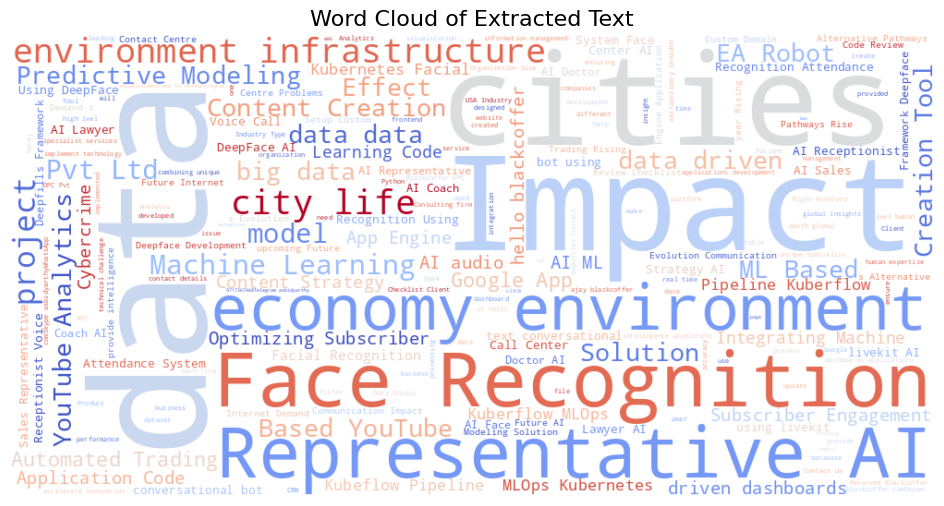

In [80]:
# Load and combine all text files into one string
text_data = ""
for file in os.listdir(TEXT_DIR):
    with open(os.path.join(TEXT_DIR, file), 'r', encoding='utf-8') as f:
        text_data += f.read() + " "

# Generate Word Cloud
wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='coolwarm').generate(text_data)

# Display the Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Extracted Text", fontsize=16)
plt.show()

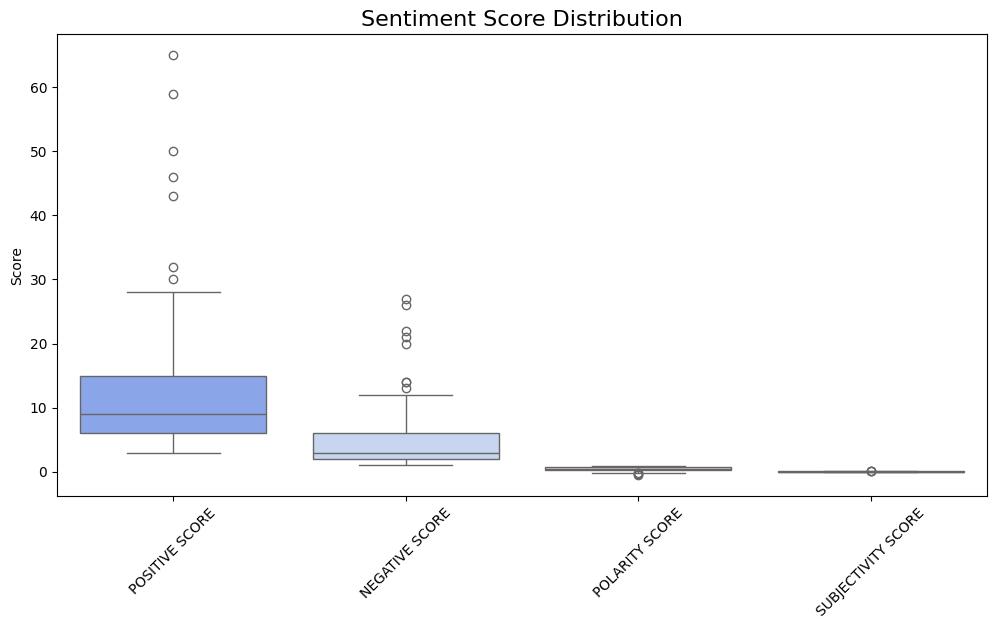

In [5]:
# Load the sentiment scores from the output file
df = pd.read_excel("Final_Output_Data.xlsx")

# Select only the required columns
sentiment_data = df[['POSITIVE SCORE', 'NEGATIVE SCORE', 'POLARITY SCORE', 'SUBJECTIVITY SCORE']]

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=sentiment_data, palette="coolwarm")
plt.title("Sentiment Score Distribution", fontsize=16)
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

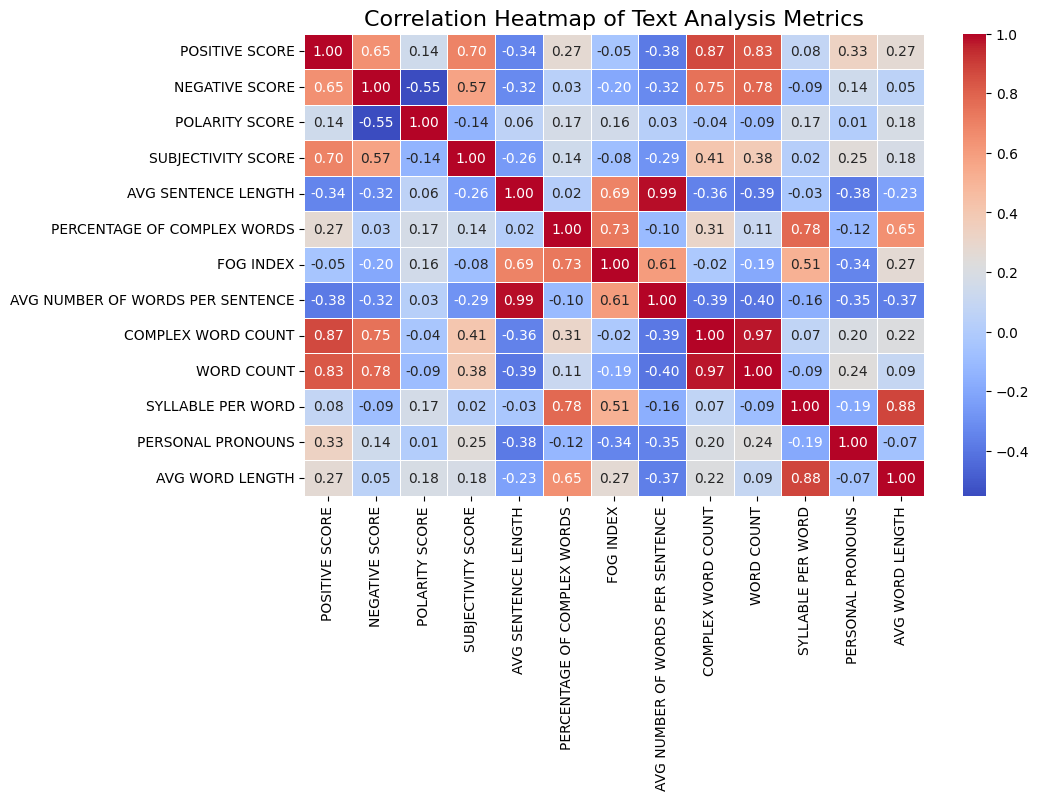

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load Data
df = pd.read_excel("Final_Output_Data.xlsx")

# Select only numeric columns for correlation
df_numeric = df.select_dtypes(include=['int64', 'float64', 'number'])

# Compute correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Plot title
plt.title("Correlation Heatmap of Text Analysis Metrics", fontsize=16)
plt.show()

In [83]:
# Scatter plot of Polarity vs Subjectivity Score
fig = px.scatter(df, x="POLARITY SCORE", y="SUBJECTIVITY SCORE", hover_name=df.index,
                 color="POLARITY SCORE", title="Polarity vs Subjectivity", color_continuous_scale='RdBu')

fig.show()

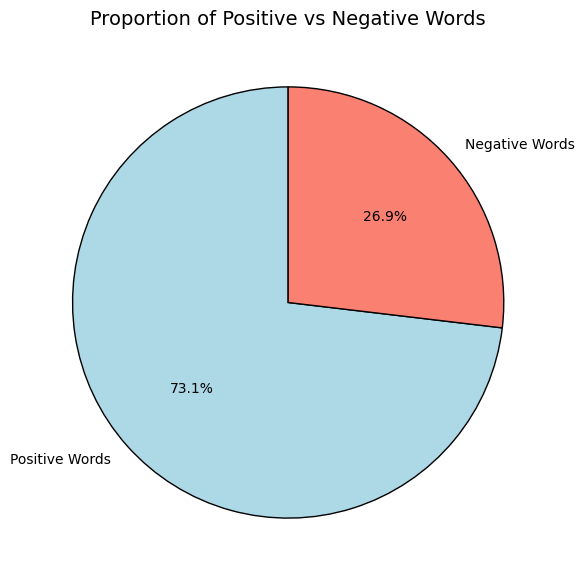

In [84]:
# Compute total positive and negative words
total_positive = df["POSITIVE SCORE"].sum()
total_negative = df["NEGATIVE SCORE"].sum()

# Pie chart data
labels = ['Positive Words', 'Negative Words']
sizes = [total_positive, total_negative]
colors = ['lightblue', 'salmon']

# Plot Pie Chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title("Proportion of Positive vs Negative Words", fontsize=14)
plt.show()

<ipython-input-85-019dfe5afa9d>:5: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-85-019dfe5afa9d>:8: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




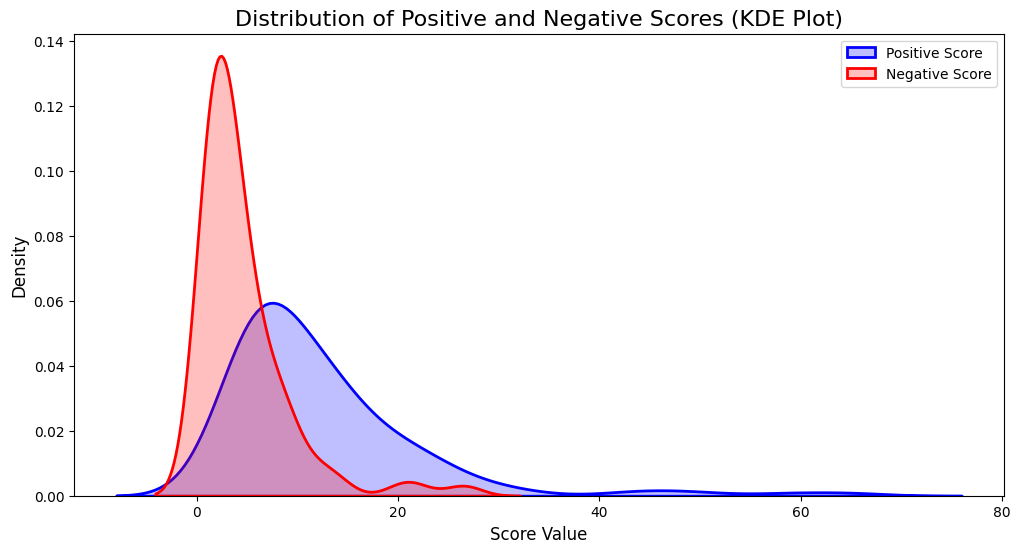

In [85]:
# Create KDE plots
plt.figure(figsize=(12, 6))

# KDE plot for Positive Score
sns.kdeplot(df["POSITIVE SCORE"], shade=True, color="blue", label="Positive Score", linewidth=2)

# KDE plot for Negative Score
sns.kdeplot(df["NEGATIVE SCORE"], shade=True, color="red", label="Negative Score", linewidth=2)

# Plot title and labels
plt.title("Distribution of Positive and Negative Scores (KDE Plot)", fontsize=16)
plt.xlabel("Score Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()

# Show the plot
plt.show()